# EJERCICIOS

In [37]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from tensorflow.keras.datasets import mnist # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Input # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

## EJERCICIO 1

¿Cuántas neuronas hacen falta en la capa de salida para clasificar emails entre correo no deseado y correo deseado? 

2 neuronas de salida, una para correo deseado y otra para no deseado.


¿Qué función de activación deberías usar en la capa de salida? 



Si, en cambio, quieres enfrentarte a MNIST, ¿cuántas neuronas necesitas en la capa de salida y qué función de activación deberías usar? 



¿Y si quieres que la red prediga los precios de la vivienda en California?

## EJERCICIO 2

Entrena un red neuronal profunda con el conjunto de datos MNIST (puedes cargarlo con tf. keras. datasets.minst.load_data()). Intenta conseguir la mejor pruebas en el conjunto de validación  ajustando los hiperparámetros de modo manual. Prueba a buscar una buena tasa de aprendizaje y utiliza la detención temprana (mínimo hay que conseguir un 97%).

Pasos a seguir: 
+ Entrena varios modelos con distintas tasas de aprendizaje
+ Guarda cada modelo en un fichero
+ Carga cada modelo y evalúalo en el conjunto de cargas y quedate con programación con el mejor (bucle que se quede con el mejor), mostrando la tasa de aprendizaje y la exactitud del mejor modelo.

Si no obtienes más de un 97% vuelve a empezar.

In [39]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [40]:
x_train, x_test = x_train / 255.0, x_test / 255.0

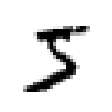

In [41]:
plt.figure(figsize=(1.2, 1.2))
plt.imshow(x_train[0], cmap="binary",interpolation="nearest")
plt.axis('off')
plt.show()

Hago una función para crear un modelo que recibe el learning rate

In [42]:
def crear_modelo(learning_rate):
    modelo = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    optimizador = Adam(learning_rate=learning_rate)
    
    modelo.compile(
        optimizer=optimizador,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return modelo


Pasarle a la función diferentes learning rates

In [43]:
tasas_aprendizaje = [0.001, 0.01, 0.1]
mejores_resultados = []

for lr in tasas_aprendizaje:
    modelo = crear_modelo(lr)
    
    # Entrenar modelo
    historia = modelo.fit(
        x_train, y_train, 
        validation_split=0.2,
        epochs=20,
        verbose=0
    )
    
    # Evaluar modelo
    perdida, exactitud = modelo.evaluate(x_test, y_test)
    
    # Guardar resultados
    mejores_resultados.append({
        'learning_rate': lr,
        'accuracy': exactitud
    })
    
    # Guardar modelo
    modelo.save(f'modelo_lr_{lr}.h5')


2024-12-16 20:26:17.125802: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.
2024-12-16 20:26:20.481003: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37632000 exceeds 10% of free system memory.


 63/313 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.9741 - loss: 0.1290

2024-12-16 20:27:14.076775: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.9713 - loss: 0.1519


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.9582 - loss: 0.3707


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.2108 - loss: 2.0149


Seleccionar mejor modelo

In [44]:
# Encontrar modelo con mayor exactitud
mejor_modelo = max(mejores_resultados, key=lambda x: x['accuracy'])

print(f"Mejor tasa de aprendizaje: {mejor_modelo['learning_rate']}")
print(f"Exactitud: {mejor_modelo['accuracy']}")

Mejor tasa de aprendizaje: 0.001
Exactitud: 0.9753999710083008


Si tiene > 97% OK, si no, volver a empezar

In [ ]:
if mejor_modelo['accuracy'] < 0.97:
    print("No llega a el 97% de exactitud. Volver a empezar :(")
else:
    print("Llega a el 97% de exactitud. Yay! :)")


## EJERCICIO 3

Clasificación de Imágenes de Dígitos Escritos a Mano:

* Objetivo: Entrenar una red neuronal para clasificar imágenes de dígitos escritos a mano utilizando el conjunto de datos SVHN (Street View House Numbers).

* Tareas: 
    * Cargar el conjunto de datos, dividir los datos (train, valid y test), explorar los datos representando alguna imagen con su etiqueta y muestra los valores (únicos) de y (en el entrenamiento, en validación y en pruebas), preparar los datos (d normalizar dividiendo entre 255.0 e igual hay que hacer algo más), construir, compilar y entrenar una red neuronal. 

    * Utilizar detección temprana

    * Hacer una gráfica de como evoluciona accuracy y val_accuracy durante el entrenamiento

    * Si es necesario ajustar el modelo para lograr una mayor precisión.

    * Evalúar el modelo en el conjunto de test y hacer alguna predicción (representa alguna imagen con su etiqueta real y la predicha)

In [46]:
def load_svhn_data(url):
    path = tf.keras.utils.get_file("svhn.mat", url)
    data = loadmat(path)
    return np.transpose(data["X"], (3, 0, 1, 2)), data["y"].flatten()

# Cargar datos
train_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
test_url = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
X_train_full, y_train_full = load_svhn_data(train_url)
X_test, y_test = load_svhn_data(test_url)

## EJERCICIO 4

Predicción del consumo de energía:

* Objetivo: Construir una red neuronal para predecir el consumo de energía de edificios a partir de características como la temperatura, humedad, y tiempo del conjunto de datos Energy Efficiency de UCI Machine Learning Repository

* Tareas: 
    * Cargar el conjunto de datos, dividir los datos (train, valid y test), explorar los datos, preparar los datos (normalizar con una capa de normalización), construir un modelo de regresión, compilar y entrenar una red neuronal. 
    
    * Usa X1-X8 para la X e Y1-Y2 para la y

    * Ajusta el modelo hasta encontrar un error absoluto medio aceptable

    * Haz una gráfica de como evoluciona el error absoluto medio y error absoluto medio del conjunto de validación durante el entrenamiento

    * Evalúa el modelo en el conjunto de test y haz alguna predicción (muestra el valor predicho y el real)

In [47]:
# Descargar el conjunto de datos de eficiencia energética de UCI
url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx")
data = pd.read_excel(url)

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.